In [1]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 49.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=51f174b532bcb2ff659e8199121535642b7766a46454db0b4563500506e2f735
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
!wget https://raw.githubusercontent.com/EmilGou/A-Chess-Transformer/main/uci_moves.py



--2025-05-30 02:23:49--  https://raw.githubusercontent.com/EmilGou/A-Chess-Transformer/main/uci_moves.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34627 (34K) [text/plain]
Saving to: ‘uci_moves.py’

uci_moves.py        100%[===================>]  33.82K  --.-KB/s    in 0.004s  

2025-05-30 02:23:49 (9.42 MB/s) - ‘uci_moves.py’ saved [34627/34627]



In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/A_Chess_Transformer/Data/1.moves"

moves = open(path, "r").read()
moves = moves.split('\n\n')[:-1]
GAMES = [m.split('\n')[:-1] for m in moves]

In [ ]:
from uci_moves import UCI_MOVES

In [ ]:
import chess

UCI_IDS = {v: k for k, v in UCI_MOVES.items()}

# 2) BUILD FEN VOCABULARY (covers full FEN)
FEN_CHARS = [
    '/', ' ', '-',                             # separators & dash
    'P','N','B','R','Q','K',
    'p','n','b','r','q','k',                   # pieces
    '0','1','2','3','4','5','6','7','8','9',    # digits for counters
    'a','b','c','d','e','f','g','h'            # files (en passant targets)
]
FEN_CHAR_TO_ID = {c: i + len(UCI_MOVES) for i, c in enumerate(FEN_CHARS)}
ID_TO_FEN_CHAR = {v: k for k, v in FEN_CHAR_TO_ID.items()}

# Compute next available index
max_idx = max(FEN_CHAR_TO_ID.values())

# ——————————————————————————————————————————————————————————————————————
# 3) SPECIAL TOKENS
SPECIAL_TOKENS = {
    "<board>":   max_idx + 1,
    "</board>":  max_idx + 2,
    "<moves>":   max_idx + 3,
    "</moves>":  max_idx + 4,
    "<pad>":     max_idx + 5,
}
ID_TO_SPECIAL = {v: k for k, v in SPECIAL_TOKENS.items()}

# ——————————————————————————————————————————————————————————————————————
# 4) TOKENIZERS / UNTOKENIZER
def tokenize_fen(fen: str) -> list[int]:
    """
    Turn the full FEN string (all 6 fields) into token IDs,
    one per character, dropping only chars not in our vocab.
    """
    return [FEN_CHAR_TO_ID[c] for c in fen if c in FEN_CHAR_TO_ID]

def tokenize_uci(moves: list[str]) -> list[int]:
    return [UCI_MOVES[m] for m in moves if m in UCI_MOVES]

def untokenize(tokens: list[int]) -> list[str]:
    out = []
    for t in tokens:
        if t in ID_TO_SPECIAL:
            out.append(ID_TO_SPECIAL[t])
        elif t in ID_TO_FEN_CHAR:
            out.append(ID_TO_FEN_CHAR[t])
        elif t in UCI_IDS:
            out.append(UCI_IDS[t])
        else:
            out.append(f"<unk:{t}>")
    return out


In [ ]:
class ChessGameDataset(torch.utils.data.Dataset):
    def __init__(self, games: list[list[str]], max_seq_len: int):
        self.games = games
        self.max_seq_len = max_seq_len
        self.pad_token = SPECIAL_TOKENS["<pad>"]

    def __len__(self):
        return len(self.games)

    def __getitem__(self, idx):
        # 1) split and pick random cut
        moves = [m.lower() for m in self.games[idx]]
        cutoff = random.randint(1, len(moves) - 1)
        past, future = moves[:cutoff], moves[cutoff:]

        # 2) build FEN from past
        board = chess.Board()
        for m in past:
            board.push_uci(m)
        fen = board.fen()  # full 6-field FEN

        # 3) tokenize
        fen_tokens    = tokenize_fen(fen)
        future_tokens = tokenize_uci(future)

        # 4) assemble input + labels
        input_seq = (
            [SPECIAL_TOKENS["<board>"]] +
            fen_tokens +
            [SPECIAL_TOKENS["</board>"],
             SPECIAL_TOKENS["<moves>"]] +
            future_tokens +
            [SPECIAL_TOKENS["</moves>"]]
        )
        moves_start = len(fen_tokens) + 2  # <board>, </board>
        labels = (
            [self.pad_token] * (moves_start + 1) +  # pad up through <moves>
            future_tokens +
            [self.pad_token]                     # do not predict </moves>
        )

        # 5) truncate & pad
        input_seq = (input_seq + [self.pad_token] * self.max_seq_len)[:self.max_seq_len]
        labels    = (labels    + [self.pad_token] * self.max_seq_len)[:self.max_seq_len]

        return torch.tensor(input_seq, dtype=torch.long), \
               torch.tensor(labels,    dtype=torch.long)


In [ ]:
import random
from torch.utils.data import DataLoader

# 1) Fix your random seed for reproducibility
random.seed(42)

# 2) Shuffle indices and split
n = len(GAMES)
indices = list(range(n))
random.shuffle(indices)
split = int(n * 0.8)
train_idx, test_idx = indices[:split], indices[split:]

# 3) Slice out train / test game‐lists
train_games = [GAMES[i] for i in train_idx]
test_games  = [GAMES[i] for i in test_idx]

# 4) Create datasets
max_len = 196
train_ds = ChessGameDataset(train_games, max_seq_len=max_len)
test_ds  = ChessGameDataset(test_games,  max_seq_len=max_len)

# 5) Create loaders
bsz = 32
train_loader = DataLoader(train_ds, batch_size=bsz, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=bsz, shuffle=False)

# Visualize
for idx, (batch, labels) in enumerate(train_loader):
    print(batch[0], labels[0])
    print(untokenize([batch[0,75].item()]))
    print("Decoded batch:")
    print(untokenize([labels[0, 76].item()]))
    print(untokenize(batch[0].tolist()))
    print("Decoded labels:")
    print(untokenize(labels[0].tolist()))
    if idx == 1:
      break

tensor([2002, 1981, 1987, 1979, 1981, 1983, 1985, 1969, 1989, 1978, 1978, 1985,
        1969, 1989, 1979, 1973, 1985, 1969, 1978, 1985, 1972, 1989, 1969, 1986,
        1974, 1974, 1988, 1969, 1978, 1972, 1990, 1969, 1989, 1972, 1985, 1972,
        1969, 1986, 1977, 1987, 1975, 1985, 1970, 1995, 1970, 1971, 1970, 1971,
        1970, 1984, 1970, 1986, 1992, 2003, 2004, 1673, 1754, 1268,  367,   98,
         221,  153,  181,  342, 1126, 1717,  448, 1567,  613, 1075,  426, 1054,
         471, 1643,  366,  255,   32,  207,  538,  371,  669,  500,   51, 1257,
         474,  309, 1234, 1084, 1319, 1096, 1207,  886,  841, 1053,  809,  954,
         260, 1020, 1338, 1324,  699, 1053, 1188,  572, 1357, 1023,  258,  944,
         425, 1202,   77, 1047,  909,  875,  242, 1396,  448, 1254, 1225, 1396,
        1079, 1244, 1376,  729,  475,  877,  272,  903,  640,  519,  483, 1435,
        1395, 1275, 1047, 1244,  858,  711,  431,  519,  613,  710,  840,  901,
         996, 1442, 1226, 1416, 1395, 12

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class AutoregressiveTransformer(nn.Module):
    """A minimal decoder‑only (causal) Transformer with **learned** positional embeddings.

    ‑ ``batch_first`` everywhere
    ‑ uses ``nn.Embedding`` for positions instead of sinusoidal features
    ‑ retains a simple causal mask for autoregressive modelling
    """

    def __init__(
        self,
        vocab_size: int,
        d_model: int = 512,
        n_heads: int = 8,
        num_layers: int = 6,
        d_ff: int = 2048,
        max_len: int = 512,
        dropout: float = 0.1,
        pad_id: int = 0,
    ) -> None:
        super().__init__()
        self.pad_id = pad_id
        self.max_len = max_len

        # Embeddings
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.n_heads = n_heads

        # Transformer blocks (encoder‑layer reused for decoder‑only stack)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Language‑model head shares weight matrix with token_emb if desired (not tied here)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # Initialize position embedding with small variance
        nn.init.normal_(self.pos_emb.weight, mean=0.0, std=0.02)

    # ‑‑‑ utility masks ‑‑‑ -------------------------------------------------
    def _causal_mask(self, size: int, device: torch.device) -> torch.Tensor:
        """Upper‑triangular causal mask (True means *masked* for PyTorch)."""
        return torch.triu(torch.ones(size, size, dtype=torch.bool, device=device), diagonal=1)

    # ‑‑‑ forward pass ‑‑‑ ---------------------------------------------------
    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
      bsz, seq_len = tokens.shape
      if seq_len > self.max_len:
          raise ValueError(f"Sequence length {seq_len} exceeds max_len {self.max_len}.")

      pos = torch.arange(seq_len, device=tokens.device).unsqueeze(0).expand(bsz, seq_len)
      x = self.token_emb(tokens) + self.pos_emb(pos)

      attn_mask = self._causal_mask(size=seq_len, device=tokens.device)# make_custom_attention_mask(tokens)  # (B, S, S)
      # attn_mask = attn_mask.repeat_interleave(self.n_heads, dim=0)

      pad_mask = tokens.eq(self.pad_id)               # (B, S)

      x = self.transformer(x, mask=attn_mask, src_key_padding_mask=pad_mask)
      return self.lm_head(x)

In [ ]:
!pip install cairosvg
import torch
import chess
import chess.svg
import chess.pgn
import torch.nn.functional as F
import cairosvg
import imageio.v2 as imageio
import os
import random
import base64
from typing import Optional
from tempfile import TemporaryDirectory
from IPython.display import SVG, display, Video, HTML

# ——————————————————————————————————————————————————————————————————————
# 1) FULL-FEN TOKENIZER
#    consumes every character in the 6-field FEN string
def tokenize_fen(fen: str) -> list[int]:
    """
    Takes the full FEN, e.g.:
      "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
    and returns a list of character-IDs for every character that
    appears in our FEN_CHAR_TO_ID vocabulary.
    """
    return [FEN_CHAR_TO_ID[c] for c in fen if c in FEN_CHAR_TO_ID]

# ——————————————————————————————————————————————————————————————————————
# 2) SAMPLE + LOG-PROB DIAGNOSTIC
@torch.no_grad()
def sample_model_moves(model, dataset, max_moves=10, temperature=1.0, top_k=10):
    model.eval()
    device = next(model.parameters()).device

    # pick random
    idx = random.randrange(len(dataset))
    input_ids, labels = dataset[idx]
    input_ids = input_ids.unsqueeze(0).to(device)
    labels   = labels.unsqueeze(0).to(device)

    # extract full-fen from input_ids
    bs = input_ids[0]
    b0 = (bs == SPECIAL_TOKENS["<board>"]).nonzero(as_tuple=True)[0].item() + 1
    b1 = (bs == SPECIAL_TOKENS["</board>"]).nonzero(as_tuple=True)[0].item()
    fen_ids = bs[b0:b1].tolist()
    # rebuild full-fen string
    fen_chars = [ID_TO_FEN_CHAR[i] for i in fen_ids]
    fen_full = "".join(fen_chars)
    # now fen_full contains e.g. "rnbqkbnr/... w KQkq - 0 1"
    board = chess.Board(fen=fen_full)

    display(SVG(chess.svg.board(board=board, size=350)))
    print("📍 Full FEN:", fen_full, "\n")

    # show tokens
    print("Input tokens: ", " ".join(untokenize(input_ids[0].tolist())))
    print("Label tokens:", " ".join(untokenize(labels[0].tolist())), "\n")

    # teacher-forcing loss
    inp  = input_ids[:, :-1]
    targ = labels[:,  1:]
    logits = model(inp)                   # (1, S-1, V)
    logp   = F.log_softmax(logits, dim=-1)

    ll = []
    for i in range(targ.size(1)):
        tid = targ[0, i].item()
        if tid == SPECIAL_TOKENS["<pad>"]:
            continue
        p = logp[0, i, tid].item()
        print(f" Step {i:2d} P({untokenize([tid])[0]}) = {math.exp(p):.4f}  logp={p:.4f}")
        ll.append(p)
    if ll:
        avg = sum(ll)/len(ll)
        print(f"\n→ mean NLL: {-avg:.4f}, ppl: {math.exp(-avg):.2f}\n")
    else:
        print("⚠️ no valid labels for loss\n")

    # sample future moves
    ms = SPECIAL_TOKENS["<moves>"]
    me = SPECIAL_TOKENS["</moves>"]
    start = (bs==ms).nonzero(as_tuple=True)[0].item()+1
    gen = bs[:start].tolist()

    for _ in range(max_moves):
        x = torch.tensor(gen, device=device).unsqueeze(0)
        lg = model(x)[0,-1,:]/temperature
        if top_k:
            v,i = torch.topk(lg, top_k)
            pr = F.softmax(v, dim=0)
            nxt = i[torch.multinomial(pr,1)].item()
        else:
            pr = F.softmax(lg, dim=-1)
            nxt = torch.multinomial(pr,1).item()
        if nxt in (me, SPECIAL_TOKENS["<pad>"]):
            break
        gen.append(nxt)

    sampled = [UCI_IDS[t] for t in gen[start:] if t in UCI_IDS]
    actual  = [UCI_IDS[t] for t in labels[0,start:].tolist() if t in UCI_IDS]
    print("🔮 Sampled:", " ".join(sampled))
    print("✅ Ground truth:", " ".join(actual))
    return sampled

# ——————————————————————————————————————————————————————————————————————
# 3) SAMPLE FULL GAME → MP4 AT CORRECT FEN
@torch.no_grad()
def sample_game_to_video(
    model,
    max_moves: int = 50,
    temperature: float = 1.0,
    top_k: int = 10,
    video_path: str = "sample_game.mp4",
    frame_duration: float = 1.2
) -> Optional[chess.pgn.Game]:
    model.eval()
    device = next(model.parameters()).device

    # start from initial
    board = chess.Board()
    # you can also push a first move, e.g. board.push_uci("e2e4")

    # build initial input
    fen_ids = tokenize_fen(board.fen())
    seq = ([SPECIAL_TOKENS["<board>"]] +
           fen_ids +
           [SPECIAL_TOKENS["</board>"], SPECIAL_TOKENS["<moves>"]])
    gen = torch.tensor(seq, device=device).unsqueeze(0)[0].tolist()

    game = chess.pgn.Game()
    last = None

    fps = 1.0/frame_duration
    with TemporaryDirectory() as tmp:
        frames = []
        # frame 0
        svg0 = chess.svg.board(board=board, size=350, lastmove=last)
        p0   = os.path.join(tmp, "f000.svg")
        png0 = os.path.join(tmp, "f000.png")
        open(p0,"w").write(svg0)
        cairosvg.svg2png(url=p0, write_to=png0)
        frames.append(png0)

        for i in range(1, max_moves+1):
            x = torch.tensor(gen, device=device).unsqueeze(0)
            lg = model(x)[0,-1,:]/temperature
            if top_k:
                v,iid = torch.topk(lg, top_k)
                pr     = F.softmax(v, dim=0)
                tok    = iid[torch.multinomial(pr,1)].item()
            else:
                pr  = F.softmax(lg,dim=-1)
                tok = torch.multinomial(pr,1).item()
            if tok in (SPECIAL_TOKENS["</moves>"], SPECIAL_TOKENS["<pad>"]):
                break
            gen.append(tok)
            if tok not in UCI_IDS:
                print("⚠️ unk", tok); break
            m = chess.Move.from_uci(UCI_IDS[tok])
            if not board.is_legal(m):
                print("⛔ illegal", UCI_IDS[tok]); break
            board.push(m); last=m; game.add_variation(m)

            svgi = chess.svg.board(board=board, size=350, lastmove=last)
            pi   = os.path.join(tmp, f"f{i:03}.svg")
            pngi = os.path.join(tmp, f"f{i:03}.png")
            open(pi,"w").write(svgi)
            cairosvg.svg2png(url=pi, write_to=pngi)
            frames.append(pngi)

        # write mp4 with correct fps
        writer = imageio.get_writer(video_path, format="ffmpeg", fps=fps)
        for p in frames:
            writer.append_data(imageio.imread(p))
        writer.close()

    display(Video(video_path, embed=True, html_attributes="controls autoplay loop"))
    print(f"✅ Video saved @ {fps:.2f} fps → {video_path}")
    return game


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
import torch
import chess
import chess.pgn
import chess.svg
import torch.nn.functional as F
import cairosvg
import imageio.v2 as imageio
import os
import random
import base64
from typing import Optional
from tempfile import TemporaryDirectory
from IPython.display import Video, display

@torch.no_grad()
def sample_game_masked(
    model,
    max_moves: int = 50,
    temperature: float = 1.0,
    video_path: str = "sample_game_masked.mp4",
    frame_duration: float = 1.2  # seconds per frame
) -> Optional[chess.pgn.Game]:
    """
    Samples a full game, but at each step:
      • Enumerates board.legal_moves
      • Converts them to your UCI token IDs
      • Masks out all other logits
      • Samples from the remaining legal‐move distribution
    Saves as MP4 at fps = 1/frame_duration.
    """
    model.eval()
    device = next(model.parameters()).device

    board = chess.Board()
    # Optionally seed first move:
    # board.push_uci("e2e4")

    # Build initial context
    fen_ids = tokenize_fen(board.fen())
    seq = [SPECIAL_TOKENS["<board>"]] + fen_ids + [
        SPECIAL_TOKENS["</board>"], SPECIAL_TOKENS["<moves>"]
    ]
    generated = seq.copy()
    game = chess.pgn.Game()
    last_move = None

    fps = 1.0 / frame_duration

    with TemporaryDirectory() as tmpdir:
        frames = []
        # frame 0: starting position
        svg0 = chess.svg.board(board=board, size=350, lastmove=last_move)
        p0   = os.path.join(tmpdir, "frame_000.svg")
        png0 = os.path.join(tmpdir, "frame_000.png")
        open(p0, "w").write(svg0)
        cairosvg.svg2png(url=p0, write_to=png0)
        frames.append(png0)

        for i in range(1, max_moves+1):
            x = torch.tensor(generated, device=device).unsqueeze(0)
            logits = model(x)[0, -1, :] / temperature  # (V,)

            # build mask over vocab, -inf for illegal moves
            legal_ids = []
            for mv in board.legal_moves:
                uci = mv.uci()
                if uci in UCI_MOVES:
                    legal_ids.append(UCI_MOVES[uci])
            if not legal_ids:
                print("⛔ No legal moves tokenized – stopping.")
                break

            mask = torch.full_like(logits, float('-inf'))
            mask[legal_ids] = 0.0
            filtered_logits = logits + mask

            probs = F.softmax(filtered_logits, dim=-1)
            token = torch.multinomial(probs, num_samples=1).item()

            # stop if end-of-moves or pad
            if token in (SPECIAL_TOKENS["</moves>"], SPECIAL_TOKENS["<pad>"]):
                break
            generated.append(token)

            # apply move
            uci = UCI_IDS.get(token, None)
            if uci is None:
                print(f"⚠️ Generated unknown token {token}.")
                break
            move = chess.Move.from_uci(uci)
            if not board.is_legal(move):
                print(f"⛔ Illegal generated move: {uci}.")
                break

            board.push(move)
            last_move = move
            game.add_variation(move)

            # render frame
            svg_i = chess.svg.board(board=board, size=350, lastmove=last_move)
            pi   = os.path.join(tmpdir, f"frame_{i:03}.svg")
            pngi = os.path.join(tmpdir, f"frame_{i:03}.png")
            open(pi, "w").write(svg_i)
            cairosvg.svg2png(url=pi, write_to=pngi)
            frames.append(pngi)

        # write MP4
        with imageio.get_writer(video_path, format='ffmpeg', fps=fps) as writer:
            for p in frames:
                writer.append_data(imageio.imread(p))

    display(Video(video_path, embed=True, html_attributes="controls autoplay loop"))
    print(f"✅ Masked‐sampling video saved to {video_path} @ {fps:.2f} fps")
    return game


In [ ]:
# _ = sample_game_masked(model,
#                        max_moves=160,
#                        temperature=1.0,
#                        frame_duration=0.5,
#                        video_path="chess_masked.mp4")


In [ ]:
#Evaluations
from tqdm import tqdm
import chess
import numpy as np
import random



def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def fix_fen(fen_str: str, default_side: str = "w") -> str:
    """
    Return a six-field FEN.  If the side-to-move field is missing or blank,
    insert `default_side` ("w" by default, set to "b" if you prefer Black).
    """
    # strip outer whitespace and collapse any double spaces
    parts = [p for p in fen_str.strip().split(' ') if p != '']

    # A legal FEN must have six tokens; five means the side-to-move is missing
    if len(parts) == 5:
        parts.insert(1, default_side)

    return " ".join(parts)

def parse_fen(fen_str: str):
  parts = fen_str.split(' ')
  position = parts[0]
  turn = parts[1]
  half_move_clock = parts[4]
  full_moves = parts[5]

  return {
      "position": position,
      "turn": turn,
      "half_move_clock": int(half_move_clock),
      "full_moves": int(full_moves)
  }


def extract_fen_from_game(game_ids):
    '''
    Takes example of token ids in the format of <board>fen</board><moves> e2e4 - -  </moves> and returns the fen string.

    Args:
        game_ids (list): List of token ids.

    Returns:
        str: The FEN string.

    '''
    game = untokenize(game_ids)

    board_idx = 0
    for i, token in enumerate(game):
        if token == '<board>':
            moves_idx = i
            break
    end_board_idx = 0
    for i, token in enumerate(game):
        if token == '</board>':
            end_moves_idx = i
            break
    fen_str = ''.join(game[moves_idx+1:end_moves_idx])

    fen_str = fix_fen(fen_str)

    return fen_str


def evaluate_legal_move_accuracy(model, val_loader, n_games, seed=None, top_k=None, temperature=1.0):
    """
    Returns
    -------
    acc : float
        Fraction of sampled moves that are legal.
    mistakes : dict[str, str]
        {FEN : illegal_predicted_move}  (only entries that had mistakes)
    """
    if seed is not None:
        set_seeds(seed)
    model.eval()
    total, legal = 0, 0
    mistakes = {}

    moves_tok     = SPECIAL_TOKENS['<moves>']
    end_moves_tok = SPECIAL_TOKENS['</moves>']

    with torch.no_grad():
        games_seen = 0

        for idx, (x, y) in enumerate(val_loader):          # x: (B, L)
            if games_seen == n_games:
                break

            # ---- choose one random game in this batch ------------------------
            random_idx  = random.randint(0, x.size(0) - 1)

            # keep original names ── just slice to batch-size 1 before GPU
            input_seq   = x[random_idx:random_idx + 1, :-1].cuda(non_blocking=True)
            target_seq  = y[random_idx:random_idx + 1, 1:]        # still CPU
            logits      = model(input_seq)                        # (1, L-1, |V|)
            logits      = logits.squeeze(0)                       # (L-1, |V|)
            seq         = input_seq.squeeze(0).cpu()              # (L-1,)

            # ---- locate sentinel tokens --------------------------------------
            moves_idx_tens      = (seq == moves_tok).nonzero(as_tuple=True)[0]
            end_moves_idx_tens  = (seq == end_moves_tok).nonzero(as_tuple=True)[0]
            if moves_idx_tens.nelement() == 0 or end_moves_idx_tens.nelement() == 0:
                continue

            moves_idx      = moves_idx_tens.item()
            end_moves_idx  = end_moves_idx_tens.item()

            # ---- rebuild board up to a random position -----------------------
            current_fen = extract_fen_from_game(x[random_idx].tolist())
            board       = chess.Board(current_fen)

            pos              = random.randint(moves_idx, end_moves_idx - 2)
            num_moves_ahead  = pos - moves_idx
            for step in range(num_moves_ahead):
                tok_id = target_seq[0, moves_idx + step].item()
                board.push_uci(UCI_IDS[tok_id])

            current_fen = board.fen()

            if board.is_game_over():
                continue

            # ---- sample the model’s move at `pos` ----------------------------
            logits_vec = logits[pos] / temperature                      # shape: (|V|,)

            if top_k is not None and top_k > 0 and top_k < logits_vec.size(0):
                kth_val = torch.topk(logits_vec, top_k).values[-1]      # value of k-th largest logit
                logits_vec = torch.where(
                    logits_vec < kth_val,
                    logits_vec.new_full((), -float('inf')),              # mask everything outside top-k
                    logits_vec
                )

            probs   = torch.softmax(logits_vec, dim=-1)
            pred_id = torch.multinomial(probs, 1).item()

            pred_uci  = UCI_IDS.get(pred_id, None)


            total += 1
            try:
                move = chess.Move.from_uci(pred_uci)
            except Exception:                              # malformed UCI
                mistakes[current_fen] = pred_uci
                games_seen += 1
                continue

            if move in board.legal_moves:
                legal += 1
            else:
                mistakes[current_fen] = pred_uci

            games_seen += 1

    acc = legal / total if total else 0.0
    return acc, mistakes

def get_piece_moved(fen, uci_move):
  '''
  Returns the piece moved from the FEN and UCI move.

  Args:
    fen (str): The FEN string.
    uci_move (str): The UCI move string.

  Returns:
    str: The piece moved.
  '''
  board = chess.Board(fen)
  move = chess.Move.from_uci(uci_move)
  piece_moved = board.piece_at(move.from_square)
  if piece_moved is None:
    return 'emp'
  return piece_moved.symbol()

def evaluate_fn_across_epochs(model, val_loader, epochs, checkpoints, eval_fn, *eval_args, **eval_kwargs):
  pass #too complicated for now


In [ ]:

epochs = [1, 5, 9, 13, 17, 21, 25, 30, 35] #List of epochs to check
checkpoint_folder = "/content/drive/MyDrive/A_Chess_Transformer/chess_checkpoints/"

paths_to_checkpoints = [checkpoint_folder +
                        f"chess_v1_vocab_size=2008_pad_id=2006_d_model=1_024_d_ff=4_096_num_layers=8_epoch={i}.pt"
                        for i in epochs]

# model = AutoregressiveTransformer(vocab_size=2008, pad_id=2006, d_model=1024, d_ff=4096, num_layers=8, max_len=256+1)

# accuracies = {}
# mistakes_epochs = {}
# for idx, path in enumerate(paths_to_checkpoints):
#   print(f"Evaluating {path}")
#   state_dict = torch.load(path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
#   model.load_state_dict(state_dict['model_state'])
#   model.to('cuda')
#   model.eval()

#   acc, mistakes = evaluate_legal_move_accuracy(model, test_loader, n_games=1000, seed=666, top_k=10)

#   accuracies[epochs[idx]] = acc
#   mistakes_epochs[epochs[idx]] = mistakes
evals_path = "/content/drive/MyDrive/A_Chess_Transformer/Evals/"






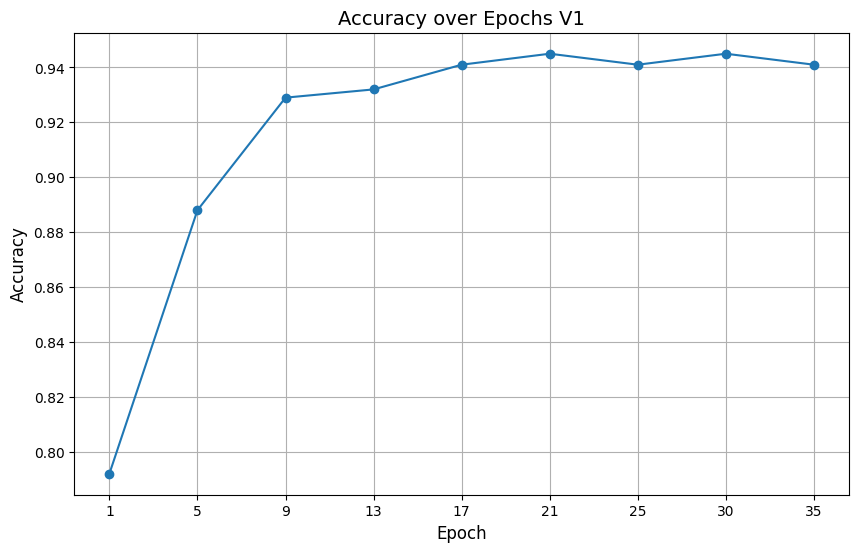

In [ ]:
# prompt: Give a nice plot of accuarcies where the keys are the epochs and the values are the accuracies

import matplotlib.pyplot as plt
import json

# Load accuracies from the JSON file
evals_path = "/content/drive/MyDrive/A_Chess_Transformer/Evals/"
with open(evals_path + "accuracies_topk=10.json", "r") as f:
    accuracies = json.load(f)

# Extract epochs and accuracies
epochs = list(accuracies.keys())
accuracies_values = list(accuracies.values())

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(epochs, accuracies_values, marker='o', linestyle='-')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy over Epochs V1", fontsize=14)
plt.grid(True)  # Add a grid for better readability
plt.xticks(epochs) #ensure all epochs are shown
plt.show()


In [ ]:
import json

with open(evals_path + "mistakes_topk=10.json", "r") as f:
    mistakes = json.load(f)

mistakes_epoch_pieces = {}
for epoch, mistakes_dict in mistakes.items():
    mistakes_pieces = {'P': 0,'N': 0,'B':0,'R':0,'Q':0,'K':0,
    'p':0,'n':0,'b':0,'r':0,'q':0,'k':0, 'emp':0 }
    for fen, move in mistakes_dict.items():
        piece = get_piece_moved(fen, move)
        mistakes_pieces[piece] += 1
    mistakes_epoch_pieces[epoch] = mistakes_pieces
mistakes_epoch_pieces


{'1': {'P': 11,
  'N': 6,
  'B': 5,
  'R': 15,
  'Q': 14,
  'K': 36,
  'p': 17,
  'n': 6,
  'b': 11,
  'r': 12,
  'q': 13,
  'k': 42,
  'emp': 20},
 '5': {'P': 7,
  'N': 3,
  'B': 6,
  'R': 12,
  'Q': 3,
  'K': 19,
  'p': 9,
  'n': 4,
  'b': 5,
  'r': 8,
  'q': 8,
  'k': 25,
  'emp': 3},
 '9': {'P': 4,
  'N': 0,
  'B': 3,
  'R': 3,
  'Q': 1,
  'K': 18,
  'p': 4,
  'n': 2,
  'b': 3,
  'r': 3,
  'q': 2,
  'k': 23,
  'emp': 5},
 '13': {'P': 5,
  'N': 0,
  'B': 2,
  'R': 10,
  'Q': 2,
  'K': 14,
  'p': 3,
  'n': 2,
  'b': 6,
  'r': 4,
  'q': 3,
  'k': 16,
  'emp': 1},
 '17': {'P': 1,
  'N': 0,
  'B': 2,
  'R': 5,
  'Q': 5,
  'K': 14,
  'p': 4,
  'n': 2,
  'b': 4,
  'r': 4,
  'q': 1,
  'k': 16,
  'emp': 1},
 '21': {'P': 4,
  'N': 4,
  'B': 1,
  'R': 5,
  'Q': 2,
  'K': 11,
  'p': 4,
  'n': 1,
  'b': 3,
  'r': 4,
  'q': 0,
  'k': 15,
  'emp': 1},
 '25': {'P': 3,
  'N': 1,
  'B': 3,
  'R': 7,
  'Q': 2,
  'K': 12,
  'p': 3,
  'n': 0,
  'b': 5,
  'r': 2,
  'q': 3,
  'k': 14,
  'emp': 4},
 '30':

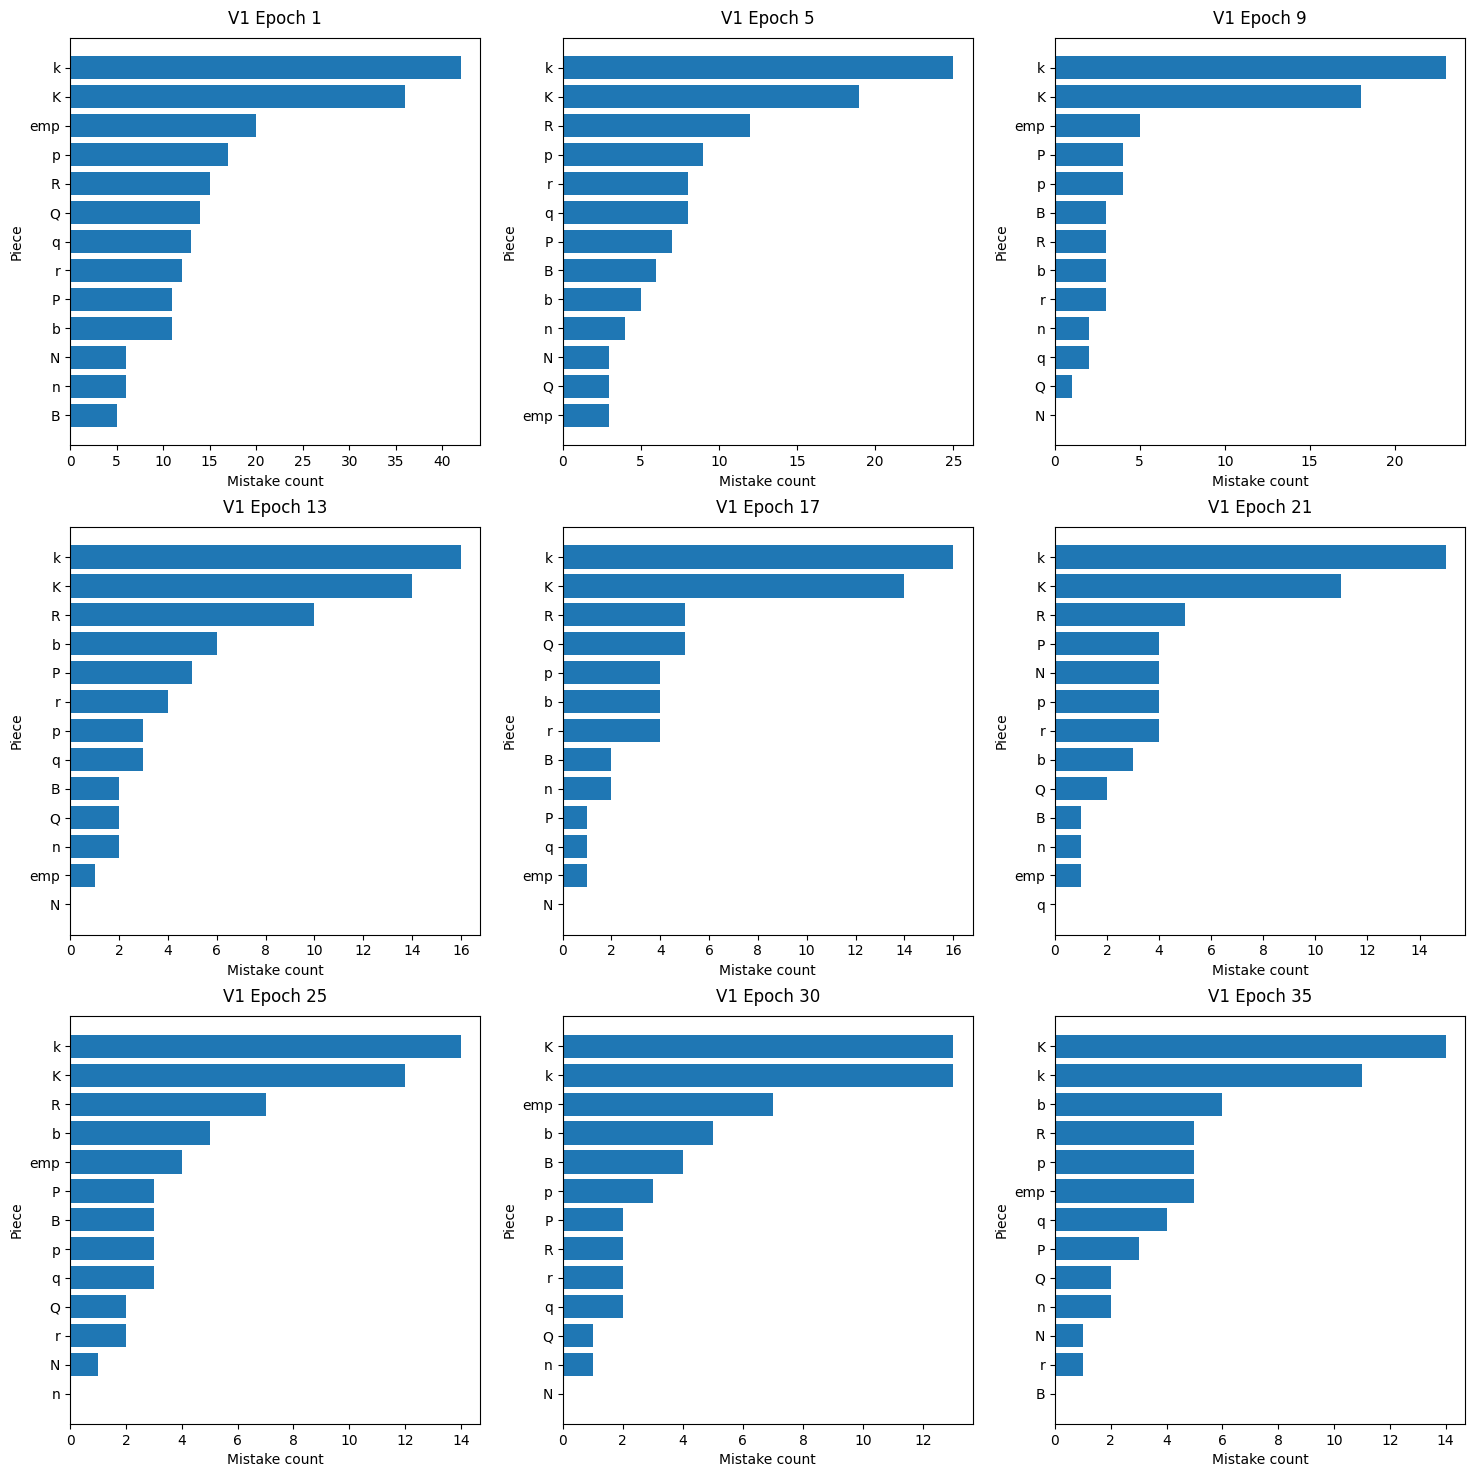

In [ ]:
import matplotlib.pyplot as plt

# ── parameters ────────────────────────────────────────────────────────────────
n_rows, n_cols = 3, 3                          # 3 × 3 grid  (up to 9 epochs)

# ── figure + axes grid ────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 6 * n_rows),
    squeeze=False,          # always 2‑D array
)

axes_flat = axes.ravel()                     # convenient 1‑D iterator

# ── plot each epoch separately ────────────────────────────────────────────────
for ax, epoch in zip(axes_flat, sorted(mistakes_epoch_pieces, key=int)):
    counts = mistakes_epoch_pieces[epoch]

    # sort *within this epoch* from most → least
    labels, values = zip(*sorted(
        counts.items(), key=lambda kv: kv[1], reverse=True
    ))

    ax.barh(labels, values)
    ax.invert_yaxis()                        # largest bar at the top
    ax.set_title(f"V1 Epoch {epoch}", pad=10)
    ax.set_xlabel("Mistake count")
    ax.set_ylabel("Piece")

# ── hide unused axes (if < 9 epochs) ─────────────────────────────────────────

In [ ]:
## Game playing evals

LICHESS_LEVELS = {
    1: {"skill_level": -9, "depth": 5, "time_constraint": .050},
    2: {"skill_level": -5, "depth": 5, "time_constraint": .100},
    3: {"skill_level": -1, "depth": 5, "time_constraint": .150},
    4: {"skill_level": 3, "depth": 5, "time_constraint": .200}
}

#Get stockfish engine
!   wget https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-sse41-popcnt.tar && \
    tar -xf stockfish-ubuntu-x86-64-sse41-popcnt.tar stockfish/stockfish-ubuntu-x86-64-sse41-popcnt

#Get fairy-stockfish engine
!wget https://github.com/fairy-stockfish/Fairy-Stockfish/releases/latest/download/fairy-stockfish-largeboard_x86-64
!chmod +x fairy-stockfish-largeboard_x86-64   # make it executable

--2025-05-05 20:11:21--  https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-sse41-popcnt.tar
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/official-stockfish/Stockfish/releases/download/sf_17.1/stockfish-ubuntu-x86-64-sse41-popcnt.tar [following]
--2025-05-05 20:11:22--  https://github.com/official-stockfish/Stockfish/releases/download/sf_17.1/stockfish-ubuntu-x86-64-sse41-popcnt.tar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/20976138/1f1e24b8-d3b0-49bf-92fd-ebd01964592a?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20250505%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20250505T201122Z&X-Amz-Expires=300&X-Amz-Signature=b137

In [ ]:
from genericpath import exists
# !pip install stockfish
from stockfish import Stockfish
from contextlib import nullcontext


def sample_move_from_model(model, seq, seq_tensor,
                           top_k=10, temperature=1.0, alpha=None,
                           mask_illegal=True, last_fen=None):
    """
    (doc‑string unchanged)
    """
    device = seq_tensor.device
    if last_fen is None and mask_illegal:
        raise ValueError("FEN must be provided if mask_illegal is True")

    board = chess.Board(last_fen) if last_fen else None


    if alpha is not None:
        moves_tok = SPECIAL_TOKENS['<moves>']
        moves_idx = (seq_tensor == moves_tok).nonzero(as_tuple=False)[0, 1]
        num_moves = seq_tensor.size(1) - moves_idx - 1
        if num_moves > alpha:
            cutoff = seq_tensor.size(1) - 1 - alpha
            to_replay_ids = seq_tensor[0, moves_idx+1:cutoff+1].cpu().tolist()
            temp_board = chess.Board(extract_fen_from_game(seq))
            for tok in to_replay_ids:
                temp_board.push_uci(UCI_IDS[tok])
            new_fen = temp_board.fen()
            prefix = ([SPECIAL_TOKENS["<board>"]] +
                      tokenize_fen(new_fen) +
                      [SPECIAL_TOKENS["</board>"], SPECIAL_TOKENS["<moves>"]])
            prefix_tensor = torch.tensor(prefix, device=device).unsqueeze(0)
            seq_tensor = torch.cat([prefix_tensor,
                                    seq_tensor[:, cutoff+1:]], dim=1)
            seq[:] = prefix + seq[cutoff+1:]

    x = seq_tensor
    logits = model(x)[0, -1, :] / temperature

    legal_ids = [UCI_MOVES[mv.uci()] for mv in board.legal_moves
                 if mv.uci() in UCI_MOVES]
    if not legal_ids:
        return "<end>", seq_tensor
    if mask_illegal:
        mask = torch.full_like(logits, float('-inf'))
        mask[legal_ids] = 0.0
        logits += mask

    if top_k is not None and 0 < top_k < logits.size(0):
        kth_val = torch.topk(logits, top_k).values[-1]
        logits = torch.where(logits < kth_val,
                             logits.new_full((), -float('inf')), logits)
    probs = F.softmax(logits, dim=-1)
    token = torch.multinomial(probs, num_samples=1).item()

    return token, seq_tensor



def model_vs_engine(model,
                    engine_type="fairy",
                    model_color="w",
                    max_moves=50,
                    skill_level=1,
                    depth = 15,
                    time_constraint = 100,
                    record=False,
                    show=False,
                    video_path="game.mp4",
                    *sample_args,
                    **sample_kwargs):
    device = next(model.parameters()).device

    board = chess.Board()
    fen = board.fen()
    seq = [SPECIAL_TOKENS["<board>"]] + tokenize_fen(fen) + [
        SPECIAL_TOKENS["</board>"], SPECIAL_TOKENS["<moves>"]]
    seq_tensor = torch.tensor(seq, device=device).unsqueeze(0)

    board = chess.Board(fen)

    if engine_type == "stockfihs":
        engine = chess.engine.SimpleEngine.popen_uci("/content/stockfish-ubuntu-x86-64-sse41-popcnt")
    elif engine_type == "fairy":
        engine = chess.engine.SimpleEngine.popen_uci("/content/fairy-stockfish-largeboard_x86-64")
    else:
        raise ValueError(f"Unknown engine type: {engine_type}")

    engine.configure({
                    "Skill Level": skill_level,
                    "Threads": 8,
                    "Hash": 8000,})





    ctx = TemporaryDirectory() if record else nullcontext()
    with ctx as tmpdir:
        if record:
            game = chess.pgn.Game()
            last_move = None
            frame_duration = 1.2
            fps = 1.0 / frame_duration
            frames = []
            svg0 = chess.svg.board(board=board, size=350, lastmove=last_move)
            p0, png0 = os.path.join(tmpdir, "frame_000.svg"), os.path.join(tmpdir, "frame_000.png")
            open(p0, "w").write(svg0); cairosvg.svg2png(url=p0, write_to=png0)
            frames.append(png0)

        for _ in range(2 * max_moves):
            if board.is_game_over():
                break
            if board.turn == chess.WHITE:
                if model_color == "w":
                    token, seq_tensor = sample_move_from_model(
                        model, seq, seq_tensor, last_fen=board.fen(),
                        *sample_args, **sample_kwargs)
                    move = UCI_IDS.get(token, None)
                    if move in ("<end>", None):
                        break
                    board.push_uci(move)
                    seq.append(token)
                    seq_tensor = torch.cat([seq_tensor,
                                            torch.tensor([[token]], device=device)], dim=1)
                    if record:
                        game.add_variation(move)
                        svg_i = chess.svg.board(board=board, size=350, lastmove=last_move)
                        pi, pngi = os.path.join(tmpdir, f"frame_{_:03}.svg"), os.path.join(tmpdir, f"frame_{_:03}.png")
                        open(pi, "w").write(svg_i); cairosvg.svg2png(url=pi, write_to=pngi)
                        frames.append(pngi)
                else:  # model_color == "b"
                    move = engine.play(board, chess.engine.Limit(depth=depth, time=time_constraint)).move.uci()
                    board.push_uci(move)
                    seq.append(UCI_MOVES[move])
                    seq_tensor = torch.cat([seq_tensor,
                                            torch.tensor([[UCI_MOVES[move]]], device=device)], dim=1)
                    if record:
                        game.add_variation(move)
                        svg_i = chess.svg.board(board=board, size=350, lastmove=last_move)
                        pi, pngi = os.path.join(tmpdir, f"frame_{_:03}.svg"), os.path.join(tmpdir, f"frame_{_:03}.png")
                        open(pi, "w").write(svg_i); cairosvg.svg2png(url=pi, write_to=pngi)
                        frames.append(pngi)
            else:  # chess.BLACK
                if model_color == "b":
                    token, seq_tensor = sample_move_from_model(
                        model, seq, seq_tensor, last_fen=board.fen(),
                        *sample_args, **sample_kwargs)
                    move = UCI_IDS.get(token, None)
                    if move == "<end>":
                        break
                    board.push_uci(move)
                    seq.append(token)
                    seq_tensor = torch.cat([seq_tensor,
                                            torch.tensor([[token]], device=device)], dim=1)
                    if record:
                        game.add_variation(move)
                        svg_i = chess.svg.board(board=board, size=350, lastmove=last_move)
                        pi, pngi = os.path.join(tmpdir, f"frame_{_:03}.svg"), os.path.join(tmpdir, f"frame_{_:03}.png")
                        open(pi, "w").write(svg_i); cairosvg.svg2png(url=pi, write_to=pngi)
                        frames.append(pngi)
                else:  # model_color == "w"
                    move = engine.play(board, chess.engine.Limit(depth=depth, time=time_constraint)).move.uci()
                    board.push_uci(move)
                    seq.append(UCI_MOVES[move])
                    seq_tensor = torch.cat([seq_tensor,
                                            torch.tensor([[UCI_MOVES[move]]], device=device)], dim=1)
                    if record:
                        game.add_variation(move)
                        svg_i = chess.svg.board(board=board, size=350, lastmove=last_move)
                        pi, pngi = os.path.join(tmpdir, f"frame_{_:03}.svg"), os.path.join(tmpdir, f"frame_{_:03}.png")
                        open(pi, "w").write(svg_i); cairosvg.svg2png(url=pi, write_to=pngi)
                        frames.append(pngi)

        if record:
            with imageio.get_writer(video_path, format='ffmpeg', fps=fps) as writer:
                for p in frames:
                    writer.append_data(imageio.imread(p))
    if show:
        display(Video(video_path, embed=True, html_attributes="controls autoplay loop"))
        print(f"✅ video saved to {video_path} @ {fps:.2f} fps")
    engine.quit()

    return board.result()


def evaluate_model_vs_engine(model,
                        n_games = 100,
                        evals_path = "/content/drive/MyDrive/A_Chess_Transformer/Evals/",
                        save_every = 25,
                        engine_config_dict = LICHESS_LEVELS,
                        engine_type="fairy",
                        *sample_args,
                        **sample_kwargs):

    os.makedirs(evals_path + f'model_eval_vids', exist_ok=True)
    results_across_elo = {tier: None for tier in engine_config_dict}
    for tier, config in engine_config_dict.items():
      skill_level, depth, time_constraint = config.values()
      results = {'win': 0, 'lose': 0, 'draw': 0}
      for i in range(n_games // 2 + 1): # white games
          record = False
          if i % save_every == 0:
            video_path = evals_path + f'model_eval_vids/game_{i}_col=w_tier={tier}.mp4'
            record = True
          result = model_vs_engine(model,
                                           engine_type = engine_type,
                                           model_color='w',
                                           skill_level=skill_level,
                                           depth=depth,
                                           time_constraint=time_constraint,
                                           record = record,
                                           video_path=video_path,
                                           *sample_args,
                                           **sample_kwargs)
          if result == '1-0':
            results['win'] += 1
          elif result == '0-1':
            results['lose'] += 1
          else:
            results['draw'] += 1

      for i in range(n_games // 2 + 1): # black games
          record = False
          if i % save_every == 0:
              video_path = evals_path + f'model_eval_vids/game_{i}_col=b_tier={tier}.mp4'
              record = True

          result = model_vs_engine(model,
                                            engine_type = engine_type,
                                            model_color='b',
                                            skill_level=skill_level,
                                            depth=depth,
                                            time_constraint=time_constraint,
                                            record = record,
                                            video_path=video_path,
                                            *sample_args,
                                            **sample_kwargs)

          if result == '0-1':
            results['win'] += 1
          elif result == '1-0':
            results['lose'] += 1
          else:
            results['draw'] += 1

      results_across_elo[tier] = results

    with open(evals_path + 'results_across_elo.json', 'w') as f:
      json.dump(results_across_elo,f)


    return results_across_elo



In [ ]:
# latest_path = "/content/drive/MyDrive/A_Chess_Transformer/chess_checkpoints/chess_v1_vocab_size=2008_pad_id=2006_d_model=1_024_d_ff=4_096_num_layers=8_latest.pt"

# model = AutoregressiveTransformer(vocab_size=2008, pad_id=2006, d_model=1024, d_ff=4096, num_layers=8, max_len=256+1)
# state_dict = torch.load(latest_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
# model.load_state_dict(state_dict['model_state'])
# model.to('cuda')
# model.eval()



#results = evaluate_model_vs_engine(model,n_games=200)

In [ ]:
with open('/content/drive/MyDrive/A_Chess_Transformer/Evals/results_across_elo.json', 'r') as f:
    results_across_elo = json.load(f)
results_across_elo

{'1': {'win': 129, 'lose': 0, 'draw': 73},
 '2': {'win': 88, 'lose': 2, 'draw': 112},
 '3': {'win': 2, 'lose': 148, 'draw': 52},
 '4': {'win': 1, 'lose': 180, 'draw': 21}}

In [ ]:
!git clone https://github.com/EmilGou/A_Chess_Transformer.git

Cloning into 'A_Chess_Transformer'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 123 (delta 57), reused 68 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 8.98 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
from A_Chess_Transformer.Evals.metrics import *

In [ ]:
win_ratios = []
for tier, results in results_across_elo.items():
  wins, losses, draws = results.values()
  ratio = win_ratio(wins, losses, draws)
  win_ratios.append(ratio)
win_ratios

elo_deltas = []
elo_delta_margins = []
for tier, results in results_across_elo.items():
  wins, losses, draws = results.values()
  delta = elo_delta(wins, losses, draws)
  delta_margin = elo_delta_margin(wins, losses, draws)
  elo_deltas.append(delta)
  elo_delta_margins.append(delta_margin)
elo_deltas
elo_delta_margins

likelihood_of_superiorities = []
for tier, results in results_across_elo.items():
  wins, losses, draws = results.values()
  likelihood = likelihood_of_superiority(wins, losses)
  likelihood_of_superiorities.append(likelihood)

likelihood_of_superiorities


[1.0, 1.0, 0.0, 0.0]

In [ ]:
!pip install tabulate
import pandas as pd
from tabulate import tabulate   # pip install tabulate

elo_cleaned = [f'{elo_delta:.2f} (+-{elo_delta_margin:.2f})' for elo_delta, elo_delta_margin in zip(elo_deltas, elo_delt_margins)]

data = {'level': results_across_elo.keys(),
        'games': [200 for i in range(len(results_across_elo))],
        'wins': [results['win'] for results in results_across_elo.values()],
        'losses': [results['lose'] for results in results_across_elo.values()],
        'draws': [results['draw'] for results in results_across_elo.values()],
        'elo_delta': elo_cleaned,
        'win_ratios': win_ratios,
        'likelihood_of_superiorities': likelihood_of_superiorities}

df = pd.DataFrame(data)

table = tabulate(df, headers='keys', tablefmt='github', showindex=False)
print(table)

|   level |   games |   wins |   losses |   draws | elo_delta         |   win_ratios |   likelihood_of_superiorities |
|---------|---------|--------|----------|---------|-------------------|--------------|-------------------------------|
|       1 |     200 |    129 |        0 |      73 | 262.60 (+-39.24)  |    0.819307  |                             1 |
|       2 |     200 |     88 |        2 |     112 | 157.97 (+-30.20)  |    0.712871  |                             1 |
|       3 |     200 |      2 |      148 |      52 | -317.36 (+-47.84) |    0.138614  |                             0 |
|       4 |     200 |      1 |      180 |      21 | -487.68 (+-78.48) |    0.0569307 |                             0 |


In [ ]:
levels = [1,2,3,4]

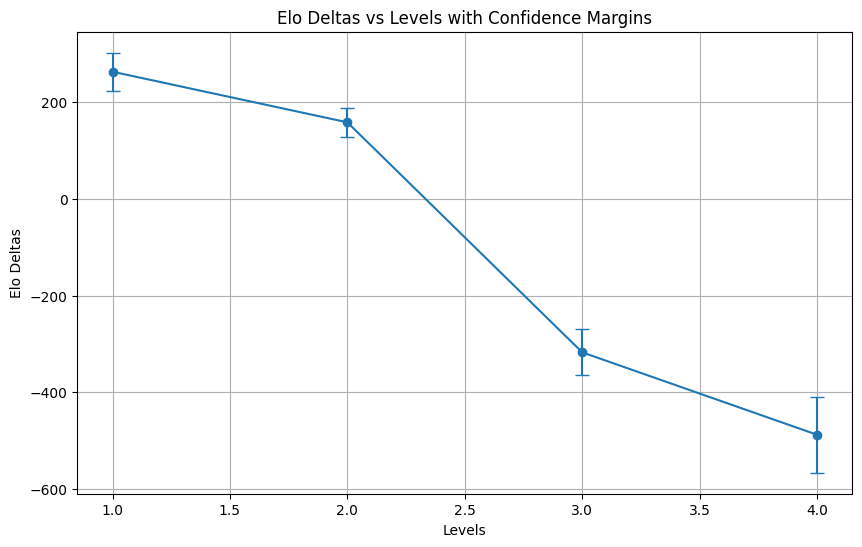

In [ ]:
# prompt: do a plot of elo_deltas vs levels and use elo_delta_margins to show confidence with a hue

import matplotlib.pyplot as plt
import pandas as pd

# Assuming elo_deltas, elo_delt_margins, and levels are defined as in the provided code
# Replace with your actual data if necessary


plt.figure(figsize=(10, 6))
plt.errorbar(levels, elo_deltas, yerr=elo_delt_margins, fmt='o-', capsize=5)
plt.xlabel("Levels")
plt.ylabel("Elo Deltas")
plt.title("Elo Deltas vs Levels with Confidence Margins")
plt.grid(True)
plt.show()


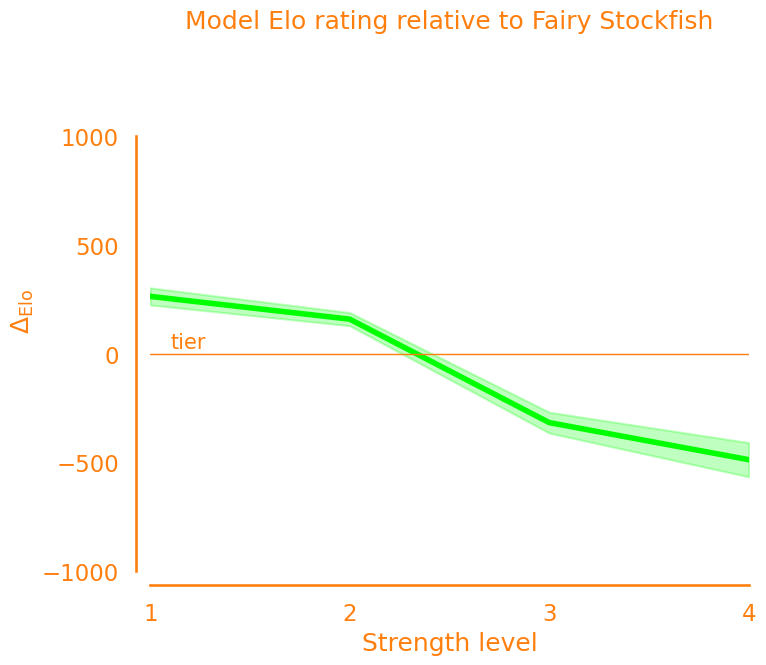

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────  1. toy data  ────────────────────
# Replace these six rows with your model’s real ΔElo ± err.
df = pd.DataFrame(
    {
        "strength": [1, 2, 3, 4],
        "elo":      elo_deltas,   # mean ΔElo
        "err":      elo_delta_margins
    }
)

# ───────────────────  2. visual style  ─────────────────
sns.set_theme(context="talk", style="dark")           # basic dark theme
orange = "#ff7f0e"
plt.rcParams.update(                                  # tweak colours
    {
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "axes.edgecolor": bla,
        "axes.labelcolor": orange,
        "xtick.color": orange,
        "ytick.color": orange,
        "text.color": orange,
        "grid.color": "#444",
    }
)

# ───────────────────  3. line + ribbon  ───────────────
fig, ax = plt.subplots(figsize=(8, 7))

# seaborn line with no CI (we’ll draw our own so it matches ΔElo ± err)
sns.lineplot(
    ax=ax,
    data=df,
    x="strength",
    y="elo",
    linewidth=4,
    color="lime",          # choose any colour you like
)

# error band
ax.fill_between(
    df["strength"],
    df["elo"] - df["err"],
    df["elo"] + df["err"],
    alpha=0.25,
    color="lime",
)

# ───────────────────  4. embellishments  ──────────────
# parity line
ax.axhline(0, color=orange, linewidth=1)
ax.text(
    df["strength"].min() + 0.1,
    5,                   # a tad above the line
    "tier",
    color=orange,
    ha="left",
    va="bottom",
    fontsize="small",
)

ax.set_title("Model Elo rating relative to Fairy Stockfish", pad=15)
ax.set_xlabel("Strength level")
ax.set_ylabel(r"$\Delta_{\mathrm{Elo}}$")

ax.set_xlim(1, 4)
ax.set_xticks(range(1, 5))
ax.set_ylim(-1000, 1400)  # match your y‑range

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()


In [ ]:
starting_fen =